# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
from tqdm import tqdm,trange

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

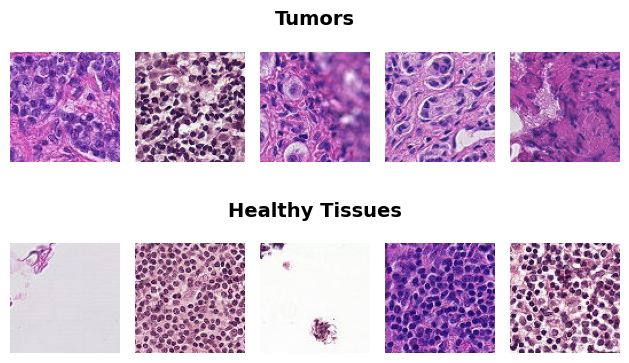

In [44]:
# download dataset
data_train = datasets.PCAM("./", split = 'val', download= True)
data_test = datasets.PCAM("./", split = 'test', download = True)

# get the first five images corresponding to a tumor or healthy tissue
tumor_images = []
healthy_images = []
for img, label in data_train:
  if label == 1 and len(tumor_images) < 5:
    tumor_images.append(img)
  if label == 0 and len(healthy_images) < 5:
    healthy_images.append(img)
  if len(tumor_images) == 5 and len(healthy_images) == 5:
    break

# Plot the images in a 2X5 grid. First row for tumor images and second for healthy tissues
fig,axes = plt.subplots(2,5)

for j in range(5):
  axes[0,j].imshow(tumor_images[j])
  axes[0,j].axis('off')

for j in range(5):
  axes[1,j].imshow(healthy_images[j])
  axes[1,j].axis('off')

fig.text(0.5, 0.87, 'Tumors', ha='center', fontsize=14, weight='bold')
fig.text(0.5, 0.47, 'Healthy Tissues', ha='center', fontsize=14, weight='bold')


plt.tight_layout()
plt.show()


Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [45]:
# define the transformation
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train.transform = tfs
data_test.transform = tfs

print(f"No. of images in data_train: {len(data_train)} \n Shape of images: {data_train[0][0].shape}")
print(f"No. of images in data_test: {len(data_test)} \n Shape of images: {data_test[0][0].shape}")



No. of images in data_train: 32768 
 Shape of images: torch.Size([3, 96, 96])
No. of images in data_test: 32768 
 Shape of images: torch.Size([3, 96, 96])


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [46]:
# creat dataloaders for train and test data
from torch.utils.data.dataloader import DataLoader
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True) #512 minibatches
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True) #512 minibatches

## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [47]:
# function to train a model given a dataloader and number of epochs
def train_model(model, dataloader, epochs):
  # Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  loss_function = nn.CrossEntropyLoss()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  loss_ac = []
  acc_ac = []
  for epoch in range(1, epochs + 1):
    model.train()
    t_loss = 0
    acc = 0
    for i,(imgs, labels) in enumerate(tqdm(dataloader)):
      imgs = imgs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      # outputs for minibatch
      output = model(imgs)

      loss = loss_function(output, labels).to('cpu')
      acc += sum(output.argmax(axis = 1) == labels).to('cpu')
      t_loss += loss

      loss.backward()

      optimizer.step()
      del imgs
      del labels
      del output
      torch.cuda.empty_cache()
    # get accuracy for this epoch
    loss_ac.append(t_loss.to('cpu'))
    acc_ac.append(acc.to('cpu'))
    print(f"Epoch {epoch} training accuracy={float(acc)/len(data_train):.3f} / Loss = {t_loss}")





  model.to('cpu')
  torch.cuda.empty_cache()


  # plot loss and accuracy during the training process
  # loss_ac = loss_ac.detach().numpy()
  loss_ac = [item.detach().numpy() for item in loss_ac]
  plt.title("Loss vs epoch")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.plot(loss_ac)
  plt.show()
  # acc_ac = acc_ac.detach().numpy()
  plt.title("Accuracy vs epoch")
  plt.ylabel("acc")
  plt.xlabel("epoch")
  acc_ac = [item.detach().numpy()/len(data_train) for item in acc_ac]
  plt.plot(acc_ac)
  plt.show()



Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [61]:
# test model
def test_model(model, dataloader):
  loss_function = nn.CrossEntropyLoss()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  acc = 0
  loss_test = 0

  for i, (input, labels) in enumerate(tqdm(dataloader)):
    input = input.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      output = model(input)

      loss_test += loss_function(output, labels)
      acc += sum(output.argmax(axis = 1) == labels)
  model.to('cpu')
  torch.cuda.empty_cache()

  print(f"Test accuracy ={float(acc)/(len(dataloader)*dataloader.batch_size) :.3f} / Loss test = {loss_test}")


## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

100%|██████████| 512/512 [00:55<00:00,  9.24it/s]


Epoch 1 training accuracy=0.578 / Loss = 1069.2470703125


100%|██████████| 512/512 [00:55<00:00,  9.26it/s]


Epoch 2 training accuracy=0.632 / Loss = 760.2608642578125


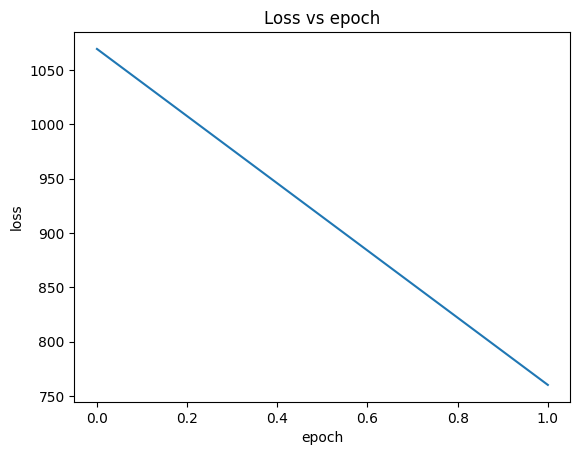

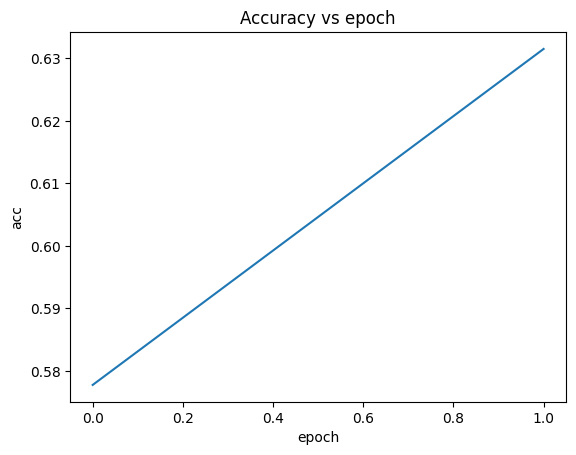

CPU times: user 1min 38s, sys: 14.3 s, total: 1min 52s
Wall time: 1min 51s


In [49]:
%%time
baseline_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(27648, 2)
)

train_model(baseline_model, train_dataloader, 2)

In [50]:
test_model(baseline_model, test_dataloader)
test_model(baseline_model, train_dataloader)


100%|██████████| 512/512 [00:54<00:00,  9.40it/s]


Test accuracy =0.596 / Loss test = 672.6665649414062


100%|██████████| 512/512 [00:54<00:00,  9.35it/s]

Test accuracy =0.753 / Loss test = 365.6864013671875


## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [51]:
# pretrained vgg16 model
model_vgg = models.vgg16(weights = 'DEFAULT')
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [52]:
# freeze all the parameters of the VGG model
for params in model_vgg.parameters():
  params.requires_grad = False

# replace last layer of classifier by a linear layer with 2 outputs
model_vgg.classifier[6] = nn.Linear(4096, 2)

# print model
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now fine-tune the model by performing 2 epochs of training.

100%|██████████| 512/512 [01:26<00:00,  5.93it/s]


Epoch 1 training accuracy=0.774 / Loss = 245.97329711914062


100%|██████████| 512/512 [01:26<00:00,  5.91it/s]


Epoch 2 training accuracy=0.786 / Loss = 240.9461669921875


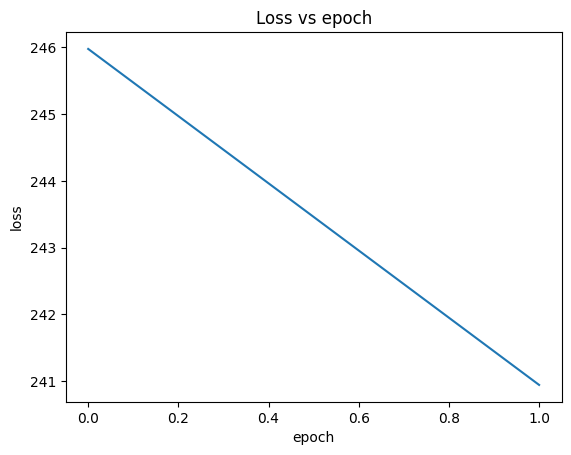

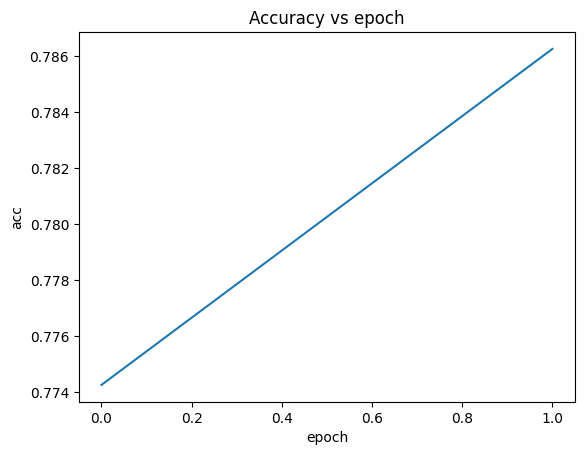

100%|██████████| 512/512 [00:55<00:00,  9.31it/s]


Test accuracy =0.703 / Loss test = 470.32818603515625
CPU times: user 3min 20s, sys: 30.3 s, total: 3min 50s
Wall time: 3min 49s


In [53]:
%%time
train_model(model_vgg, train_dataloader, 2)
test_model(model_vgg, test_dataloader)

## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [54]:
# crate a Dataset with the precomputed features
def precompute_model(model, dataloader):
  """
    This function takes a model and a dataloader as input and return a Dataset containing
    the ouputs of the model
  """
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  outputs = []
  labels = []
  with torch.no_grad():
    for i, (input, target) in enumerate(tqdm(dataloader)):
      input = input.to(device)
      target = target.to(device)

      outputs.append(model(input))
      labels.append(target)
      del input
      del target
      torch.cuda.empty_cache()


  # concat tensors
  outputs = torch.cat(outputs, dim = 0).to('cpu')
  labels = torch.cat(labels, dim = 0).to('cpu')
  model.to('cpu')
  torch.cuda.empty_cache()

  return torch.utils.data.TensorDataset(outputs, labels)





Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [55]:
%%time
train_dataloader_feat = DataLoader(precompute_model(model_vgg.features, train_dataloader), batch_size=64, shuffle=True)
test_dataloader_feat = DataLoader(precompute_model(model_vgg.features, test_dataloader), batch_size=64, shuffle=True)


100%|██████████| 512/512 [01:21<00:00,  6.30it/s]


CPU times: user 2min 23s, sys: 20.5 s, total: 2min 43s
Wall time: 2min 43s


Finally, train a linear model on the our new precomputed features for 50 epochs. Is the model better?

100%|██████████| 512/512 [00:01<00:00, 340.05it/s]


Epoch 1 training accuracy=0.844 / Loss = 180.976318359375


100%|██████████| 512/512 [00:01<00:00, 345.82it/s]


Epoch 2 training accuracy=0.877 / Loss = 148.09974670410156


100%|██████████| 512/512 [00:01<00:00, 346.10it/s]


Epoch 3 training accuracy=0.887 / Loss = 136.32986450195312


100%|██████████| 512/512 [00:01<00:00, 350.45it/s]


Epoch 4 training accuracy=0.891 / Loss = 131.8771209716797


100%|██████████| 512/512 [00:01<00:00, 347.48it/s]


Epoch 5 training accuracy=0.896 / Loss = 126.44205474853516


100%|██████████| 512/512 [00:01<00:00, 344.93it/s]


Epoch 6 training accuracy=0.899 / Loss = 124.09783172607422


100%|██████████| 512/512 [00:01<00:00, 342.51it/s]


Epoch 7 training accuracy=0.899 / Loss = 123.37987518310547


100%|██████████| 512/512 [00:01<00:00, 339.80it/s]


Epoch 8 training accuracy=0.904 / Loss = 117.43804168701172


100%|██████████| 512/512 [00:01<00:00, 338.61it/s]


Epoch 9 training accuracy=0.906 / Loss = 116.64737701416016


100%|██████████| 512/512 [00:01<00:00, 334.93it/s]


Epoch 10 training accuracy=0.909 / Loss = 112.79762268066406


100%|██████████| 512/512 [00:01<00:00, 333.63it/s]


Epoch 11 training accuracy=0.910 / Loss = 112.44425201416016


100%|██████████| 512/512 [00:01<00:00, 327.42it/s]


Epoch 12 training accuracy=0.911 / Loss = 110.30057525634766


100%|██████████| 512/512 [00:01<00:00, 327.78it/s]


Epoch 13 training accuracy=0.913 / Loss = 110.1653823852539


100%|██████████| 512/512 [00:01<00:00, 332.15it/s]


Epoch 14 training accuracy=0.914 / Loss = 108.18146514892578


100%|██████████| 512/512 [00:01<00:00, 327.69it/s]


Epoch 15 training accuracy=0.910 / Loss = 111.67313385009766


100%|██████████| 512/512 [00:01<00:00, 339.16it/s]


Epoch 16 training accuracy=0.913 / Loss = 108.95232391357422


100%|██████████| 512/512 [00:01<00:00, 349.89it/s]


Epoch 17 training accuracy=0.914 / Loss = 108.22167205810547


100%|██████████| 512/512 [00:01<00:00, 341.44it/s]


Epoch 18 training accuracy=0.916 / Loss = 105.6712646484375


100%|██████████| 512/512 [00:01<00:00, 344.00it/s]


Epoch 19 training accuracy=0.916 / Loss = 106.77635955810547


100%|██████████| 512/512 [00:01<00:00, 344.07it/s]


Epoch 20 training accuracy=0.916 / Loss = 105.39439392089844


100%|██████████| 512/512 [00:01<00:00, 339.63it/s]


Epoch 21 training accuracy=0.918 / Loss = 105.3890380859375


100%|██████████| 512/512 [00:01<00:00, 335.95it/s]


Epoch 22 training accuracy=0.915 / Loss = 105.87823486328125


100%|██████████| 512/512 [00:01<00:00, 339.71it/s]


Epoch 23 training accuracy=0.918 / Loss = 103.33602905273438


100%|██████████| 512/512 [00:01<00:00, 339.93it/s]


Epoch 24 training accuracy=0.918 / Loss = 104.95277404785156


100%|██████████| 512/512 [00:01<00:00, 337.16it/s]


Epoch 25 training accuracy=0.920 / Loss = 102.15750122070312


100%|██████████| 512/512 [00:01<00:00, 344.08it/s]


Epoch 26 training accuracy=0.919 / Loss = 102.2423324584961


100%|██████████| 512/512 [00:01<00:00, 342.45it/s]


Epoch 27 training accuracy=0.922 / Loss = 100.22116088867188


100%|██████████| 512/512 [00:01<00:00, 339.74it/s]


Epoch 28 training accuracy=0.919 / Loss = 101.93792724609375


100%|██████████| 512/512 [00:01<00:00, 339.75it/s]


Epoch 29 training accuracy=0.921 / Loss = 99.95445251464844


100%|██████████| 512/512 [00:01<00:00, 336.29it/s]


Epoch 30 training accuracy=0.922 / Loss = 99.6580810546875


100%|██████████| 512/512 [00:01<00:00, 340.21it/s]


Epoch 31 training accuracy=0.919 / Loss = 102.15071868896484


100%|██████████| 512/512 [00:01<00:00, 337.70it/s]


Epoch 32 training accuracy=0.922 / Loss = 98.66997528076172


100%|██████████| 512/512 [00:01<00:00, 346.32it/s]


Epoch 33 training accuracy=0.922 / Loss = 101.19454956054688


100%|██████████| 512/512 [00:01<00:00, 340.41it/s]


Epoch 34 training accuracy=0.919 / Loss = 101.14464569091797


100%|██████████| 512/512 [00:01<00:00, 343.98it/s]


Epoch 35 training accuracy=0.922 / Loss = 99.28711700439453


100%|██████████| 512/512 [00:01<00:00, 344.60it/s]


Epoch 36 training accuracy=0.925 / Loss = 96.11504364013672


100%|██████████| 512/512 [00:01<00:00, 334.36it/s]


Epoch 37 training accuracy=0.924 / Loss = 97.82217407226562


100%|██████████| 512/512 [00:01<00:00, 339.91it/s]


Epoch 38 training accuracy=0.926 / Loss = 97.68052673339844


100%|██████████| 512/512 [00:01<00:00, 340.44it/s]


Epoch 39 training accuracy=0.921 / Loss = 99.57042694091797


100%|██████████| 512/512 [00:01<00:00, 345.40it/s]


Epoch 40 training accuracy=0.926 / Loss = 96.58163452148438


100%|██████████| 512/512 [00:01<00:00, 339.45it/s]


Epoch 41 training accuracy=0.924 / Loss = 97.66351318359375


100%|██████████| 512/512 [00:01<00:00, 335.24it/s]


Epoch 42 training accuracy=0.923 / Loss = 99.23873901367188


100%|██████████| 512/512 [00:01<00:00, 338.00it/s]


Epoch 43 training accuracy=0.924 / Loss = 97.44595336914062


100%|██████████| 512/512 [00:01<00:00, 344.06it/s]


Epoch 44 training accuracy=0.924 / Loss = 96.35456848144531


100%|██████████| 512/512 [00:01<00:00, 344.03it/s]


Epoch 45 training accuracy=0.922 / Loss = 98.15240478515625


100%|██████████| 512/512 [00:01<00:00, 337.21it/s]


Epoch 46 training accuracy=0.927 / Loss = 95.77669525146484


100%|██████████| 512/512 [00:01<00:00, 341.45it/s]


Epoch 47 training accuracy=0.924 / Loss = 97.0518798828125


100%|██████████| 512/512 [00:01<00:00, 344.12it/s]


Epoch 48 training accuracy=0.922 / Loss = 97.83727264404297


100%|██████████| 512/512 [00:01<00:00, 339.96it/s]


Epoch 49 training accuracy=0.923 / Loss = 98.24749755859375


100%|██████████| 512/512 [00:01<00:00, 329.39it/s]


Epoch 50 training accuracy=0.924 / Loss = 97.89702606201172


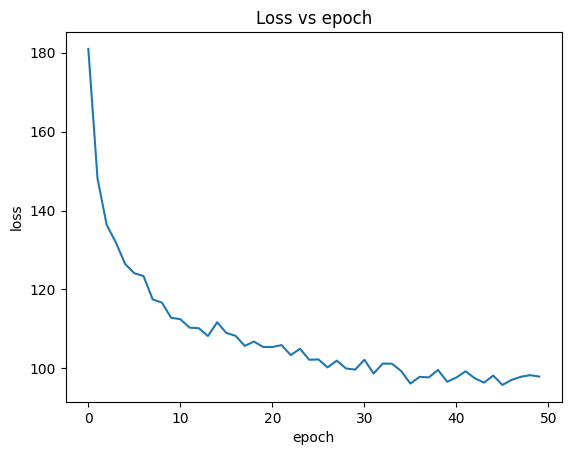

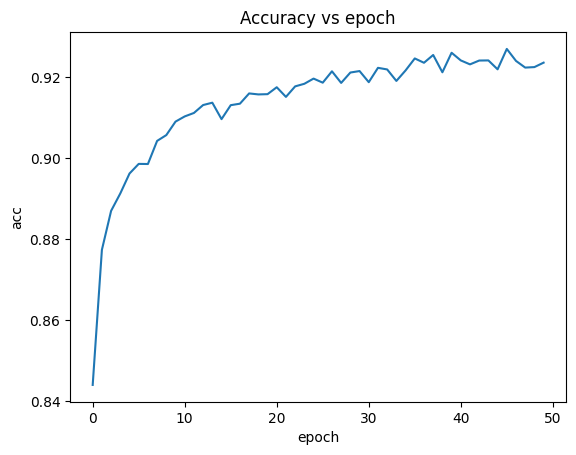

CPU times: user 1min 13s, sys: 2.1 s, total: 1min 16s
Wall time: 1min 16s


In [56]:
%%time
model_l = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512*9, 2)
)

train_model(model_l, train_dataloader_feat, 50)

In [63]:
test_model(model_l, test_dataloader_feat)

100%|██████████| 512/512 [00:00<00:00, 513.86it/s]

Test accuracy =0.723 / Loss test = 1117.7568359375
